In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import heapq

plt.rcParams.update({
    "font.family": "Nimbus Roman",
    "font.serif": ["Nimbus Roman", "Times New Roman", "Times", "DejaVu Serif", "Serif"],
    # "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.35,
    "font.size": 24, "axes.titlesize": 20, "axes.labelsize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15, "ytick.labelsize": 15,
    # "figure.figsize": (14, 5.2),   # 3 side-by-side panels
})


In [12]:
results_dir = "../results/preflib-resampling"
with open(f"{results_dir}/uncertain-subsampling-results.pickle", "rb") as f:
    sampling_results = pickle.load(f)

In [14]:
elections, ratios, num_trials, resampled_results, true_results, elim_order_in_the_limit_counts = sampling_results
# elections, ratios, num_trials, resampled_results, true_results = sampling_results
print(f"{len(elections)} elections")
print(f"ratios: {ratios}")
print(f"num trials: {num_trials}")

4 elections
ratios: [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 20.48, 327.68, 1310.72, 10737418.24, 10995116277.76]
num trials: 500


## How often does the actual winner win?

Text(0.5, 1.0, 'Winning Rate of Actual Winner by Sampling Rate')

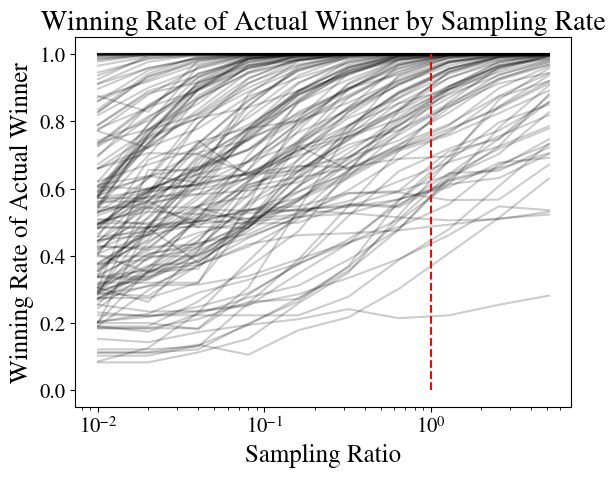

In [11]:
fig, ax = plt.subplots()

winner_sweep_elections = []
least_prob_of_victory = 1.0
most_uncertain_election = ""
non_monotonic_elections = []

winning_rates_by_election = {}

for collection, election_name in resampled_results:
    actual_winner = true_results[collection, election_name]
    winning_rates = [
        sampled_election[actual_winner] / num_trials
        for sampled_election in resampled_results[collection, election_name]
    ]
    winning_rates_by_election[collection, election_name] = winning_rates
    ax.plot(ratios, winning_rates, color="black", alpha=0.2)
    # ax.plot(ratios, winning_rates, label=f"{collection}-{election_name[-6:-4]}")

    # sweeps
    if np.sum(winning_rates) == len(ratios):
        winner_sweep_elections.append((collection, election_name))

    # most uncertain
    if winning_rates[-1] < least_prob_of_victory:
        most_uncertain_election = f"{collection}-{election_name}"
        least_prob_of_victory = winning_rates[-1]

    # non monotonic elections
    for ratio_idx in range(1, len(winning_rates)):
        if winning_rates[ratio_idx] < winning_rates[ratio_idx - 1]:
            non_monotonic_elections.append((
                f"{collection}-{election_name}",
                winning_rates
            ))
            break
    
ax.set_xscale("log")

ax.vlines(1, ymin=0, ymax=1, color="red", linestyle="--")
# ax.hlines(0.5, xmin=0, xmax=ratios[-1], color="black", linestyle="--", alpha=0.2)

ax.set_xlabel("Sampling Ratio")
ax.set_ylabel("Winning Rate of Actual Winner")
ax.set_title("Winning Rate of Actual Winner by Sampling Rate")

# ax.legend()

In [6]:
# sweeps
print(len(winner_sweep_elections))
print(winner_sweep_elections)

10
[('apa', 'ED-00028-00000001.soi'), ('apa', 'ED-00028-00000006.soi'), ('apa', 'ED-00028-00000009.soi'), ('irish', 'ED-00001-00000003.soi'), ('minneapolis', 'ED-00018-00000004.soi'), ('oakland', 'ED-00019-00000001.toi'), ('oakland', 'ED-00019-00000003.toi'), ('pierce', 'ED-00020-00000001.toi'), ('sf', 'ED-00021-00000010.toi'), ('sf', 'ED-00021-00000011.toi')]


In [7]:
# most uncertain election
print(most_uncertain_election)
print(least_prob_of_victory)

ers-ED-00007-00000005.soi
0.2814285714285714


31
ers-ED-00007-00000024.soi [0.4828571428571429, 0.4828571428571429, 0.38, 0.48428571428571426, 0.6085714285714285, 0.6857142857142857, 0.8057142857142857, 0.88, 0.9371428571428572, 0.9828571428571429]
ers-ED-00007-00000074.soi [0.45714285714285713, 0.6857142857142857, 0.7428571428571429, 0.6357142857142857, 0.7428571428571429, 0.8385714285714285, 0.9071428571428571, 0.9771428571428571, 0.9971428571428571, 1.0]


Text(0.5, 1.0, 'Winning Rate of Actual Winner by Sampling Rate')

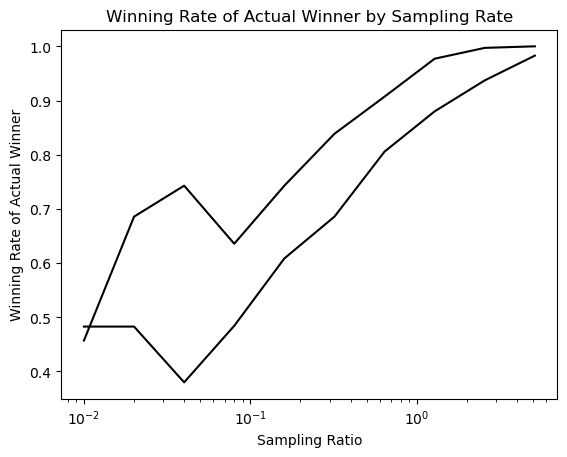

In [8]:
# non monotonic elections
print(len(non_monotonic_elections))

fig, ax = plt.subplots()
for election, winning_rates in non_monotonic_elections:
    for ratio_idx in range(1, len(winning_rates)):
        if winning_rates[ratio_idx] - winning_rates[ratio_idx - 1] < -0.1:
            ax.plot(ratios, winning_rates, color="black", label=election)
            print(election, winning_rates)

ax.set_xscale("log")
ax.set_xlabel("Sampling Ratio")
ax.set_ylabel("Winning Rate of Actual Winner")
ax.set_title("Winning Rate of Actual Winner by Sampling Rate")

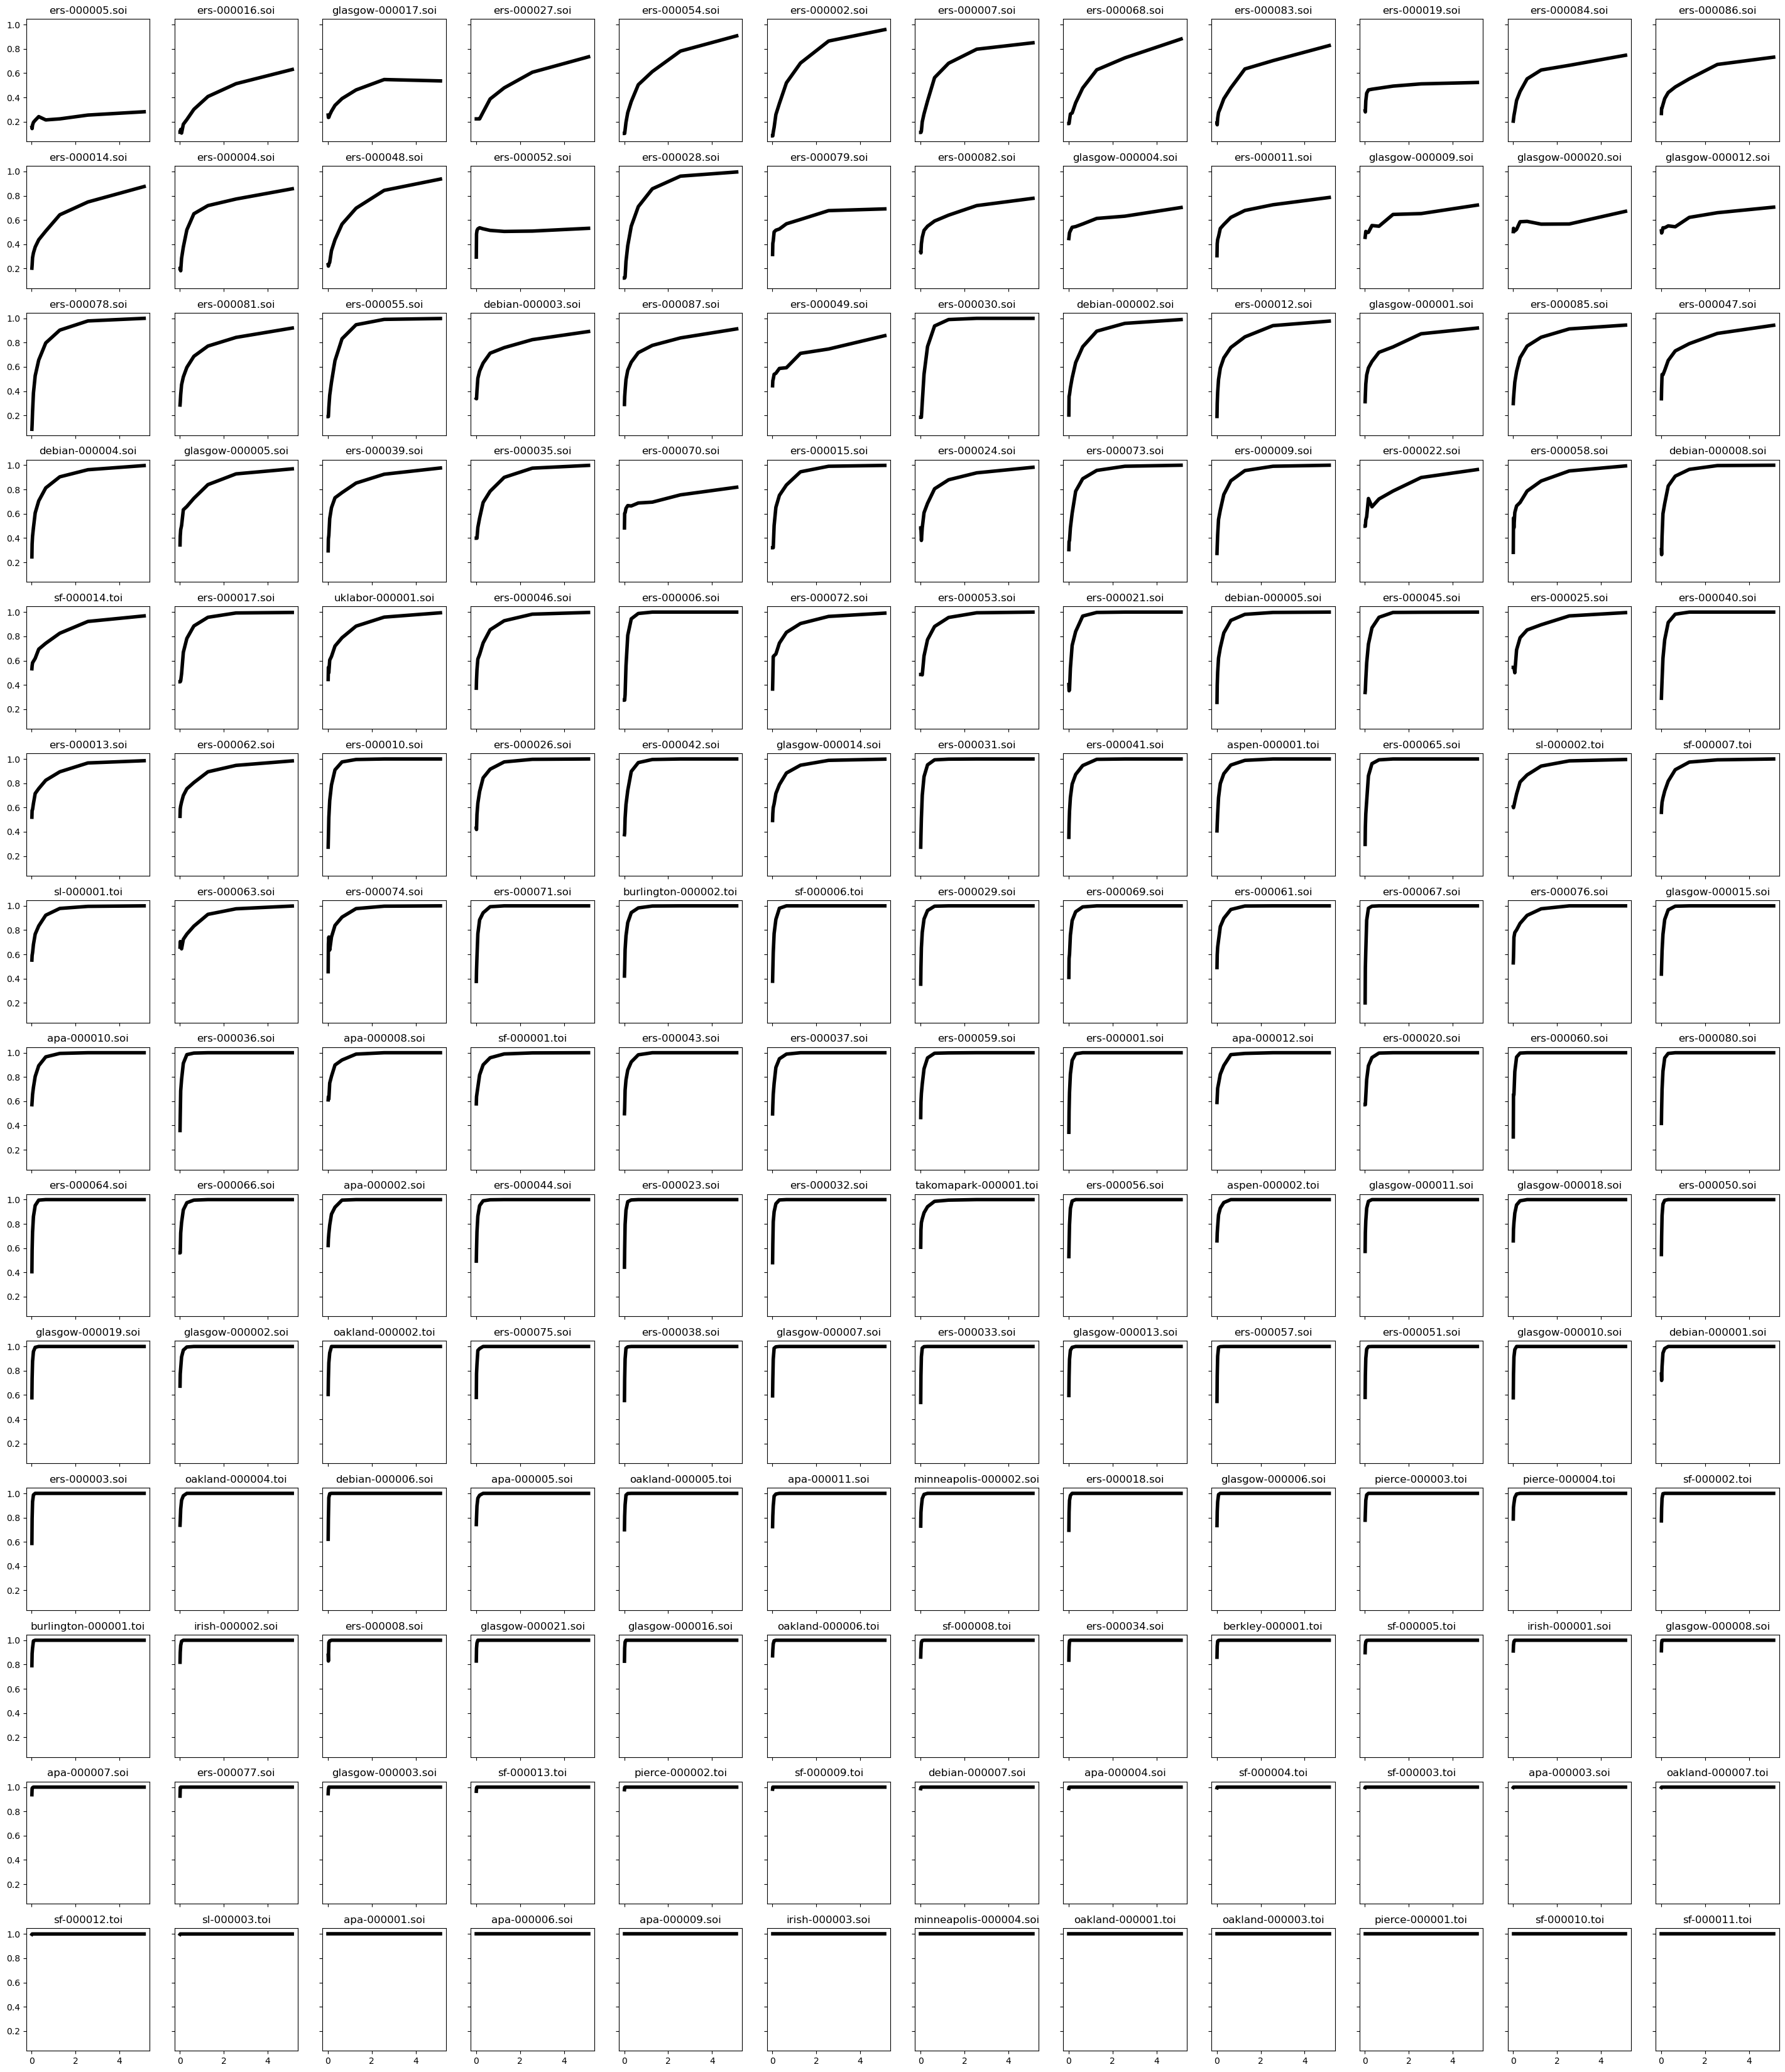

In [9]:
num_cols = 12
num_elections = len(elections)
num_rows = int(num_elections / num_cols) + 1
if num_elections % num_cols == 0:
    num_rows -= 1
    
fig, axs = plt.subplots(ncols=num_cols, nrows=num_rows, 
                        figsize=(3 * num_cols, 3 *num_rows),
                       sharex=True, sharey=True)

pq = []
for collection, election_name in winning_rates_by_election:
    winning_rates = winning_rates_by_election[collection, election_name]
    heapq.heappush(pq, (np.sum(winning_rates), (collection, election_name)))

col_idx = 0
row_idx = 0
while pq:
    total_winning_rate, (collection, election_name) = heapq.heappop(pq)

    winning_rates = winning_rates_by_election[collection, election_name]
    axs[row_idx][col_idx].plot(ratios, winning_rates, color="black", linewidth=4)
    axs[row_idx][col_idx].set_title(f"{collection}-{election_name[-10:]}")
    col_idx += 1
    if col_idx == num_cols:
        col_idx = 0
        row_idx += 1
fig.savefig("../plots/winning_rate_by_election_grid_700.pdf", bbox_inches="tight")


## Stability of elections at different sampling rates

In [10]:
threshold = 0.9
frac_stable_elections_by_sampling_ratio = []
for ratio_idx, ratio in enumerate(ratios):
    num_stable_elections = 0
    for collection, election_name in resampled_results:
        actual_winner = true_results[collection, election_name]
        if resampled_results[collection, election_name][ratio_idx][actual_winner] >= threshold * num_trials:
            num_stable_elections += 1
    num_stable_elections /= len(resampled_results)
    frac_stable_elections_by_sampling_ratio.append(num_stable_elections)

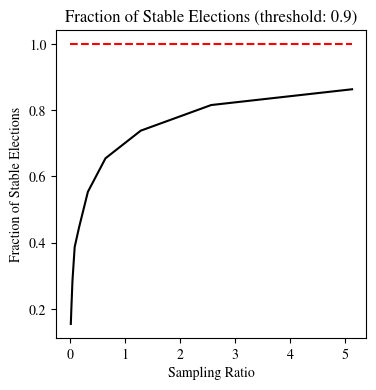

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ratios, frac_stable_elections_by_sampling_ratio, color="black")
ax.hlines(1.0, xmin=0, xmax=ratios[-1], color="red", linestyle="--")

# ax.set_xscale("log")

ax.set_xlabel("Sampling Ratio")
ax.set_ylabel("Fraction of Stable Elections")
ax.set_title(f"Fraction of Stable Elections (threshold: {threshold})")

ax.grid()

## Investigating Coin Toss Elections in the Limit

In [23]:
collection = 'glasgow'
election_name = 'ED-00008-00000012.soi'
resampled_results[collection, election_name]

[{1: 18, 2: 223, 3: 0, 4: 259, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 3, 2: 251, 3: 0, 4: 246, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 255, 3: 0, 4: 245, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 238, 3: 0, 4: 262, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 227, 3: 0, 4: 273, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 225, 3: 0, 4: 275, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 236, 3: 0, 4: 264, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 188, 3: 0, 4: 312, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 163, 3: 0, 4: 337, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 150, 3: 0, 4: 350, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 59, 3: 0, 4: 441, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 0, 3: 0, 4: 500, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 0, 3: 0, 4: 500, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 0, 3: 0, 4: 500, 5: 0, 6: 0, 7: 0, 8: 0},
 {1: 0, 2: 0, 3: 0, 4: 500, 5: 0, 6: 0, 7: 0, 8: 0}]

In [18]:
elim_order_in_the_limit_counts[collection, election_name]

{'23 24 14 17 22 15 7 5 16 8 18 2 4 21 1 26 12 6 3 25 10 19 13 9 20 11': 1,
 '23 22 15 14 18 24 17 4 16 2 8 5 7 21 1 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 24 17 22 14 15 8 7 5 18 16 2 4 21 1 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 18 15 14 22 17 24 4 8 7 5 2 16 21 1 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 14 17 22 24 15 2 16 7 8 5 18 4 21 1 26 12 6 3 25 10 19 13 9 20 11': 1,
 '23 14 15 24 17 22 5 8 2 4 16 18 7 21 1 26 6 12 3 25 10 19 13 9 20 11': 1,
 '23 15 18 14 17 22 24 2 8 7 4 5 16 1 21 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 22 15 24 17 14 7 16 8 18 2 5 4 1 21 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 24 17 15 14 22 7 5 4 16 18 8 2 21 1 26 6 12 3 25 10 19 13 9 20 11': 1,
 '23 15 22 14 17 24 7 4 16 2 5 18 8 1 21 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 17 22 14 18 15 24 16 7 4 8 2 5 1 21 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 18 14 22 24 15 17 2 5 7 4 8 16 1 21 12 26 6 3 25 10 19 13 9 20 11': 1,
 '23 17 24 22 15 14 18 16 4 5 2 8 7 1 21 26 12 6 3 25 10 19 13 9 20 11': 1,
 '23 22 24 1

In [24]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import utils

filename = f'../data/preflib/elections-all/{collection}/{election_name}'
ballots, ballot_counts, cand_names, skipped_votes = utils.read_preflib(filename)

In [25]:
def compare_two_candidates(ballots, ballot_counts, cand_a, cand_b):
    support_a = 0
    support_b = 0
    for ballot_idx, ballot in enumerate(ballots):
        for cand in ballot:
            if cand == cand_a:
                support_a += ballot_counts[ballot_idx]
                break
            elif cand == cand_b:
                support_b += ballot_counts[ballot_idx]
                break
    return support_a, support_b, np.sum(ballot_counts) - support_a - support_b

compare_two_candidates(ballots, ballot_counts, 2, 4)

(3684, 3707, 1943)

## How many contenders are there at different sampling rates?

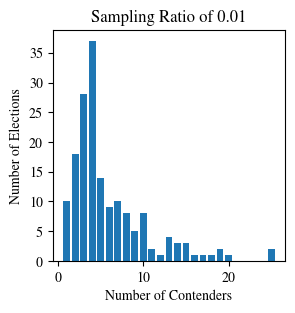

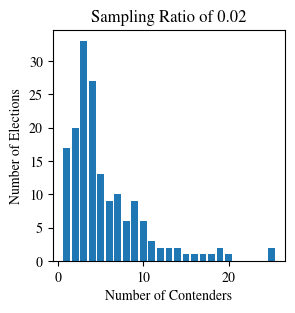

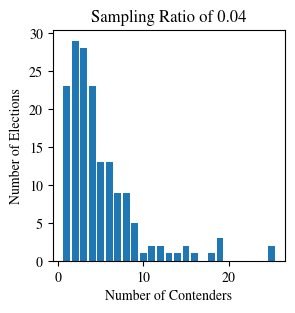

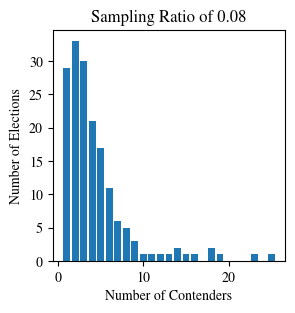

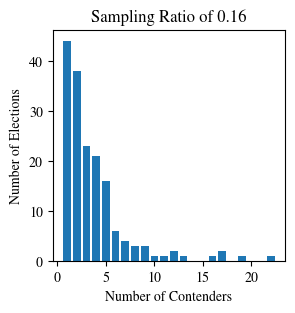

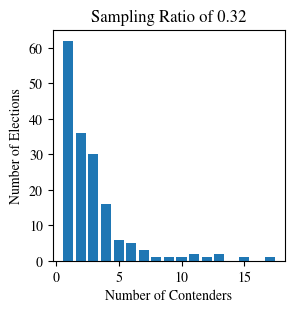

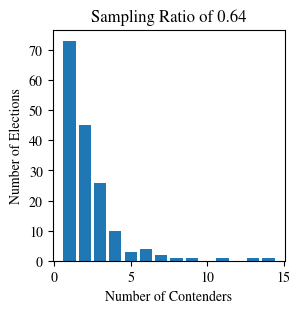

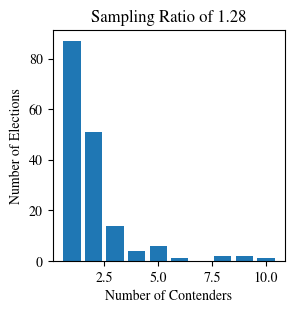

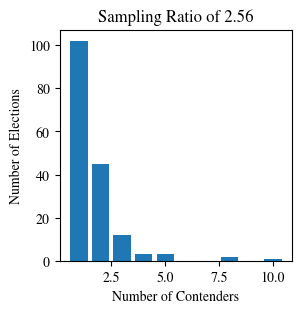

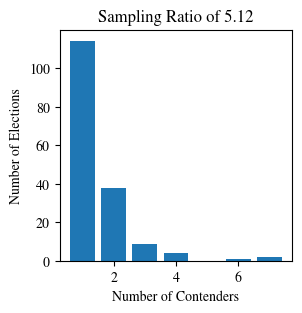

In [8]:
for ratio_idx, ratio in enumerate(ratios):
    num_contenders_to_counts = {}
    for collection, election_name in resampled_results:
        winner_counts = resampled_results[collection, election_name][ratio_idx]
        num_contenders = np.sum(np.array(list(winner_counts.values())) > 0)
        if num_contenders not in num_contenders_to_counts:
            num_contenders_to_counts[num_contenders] = 0
        num_contenders_to_counts[num_contenders] += 1

    # print(f"{ratio} \n {num_contenders_to_counts}")
    fig, ax = plt.subplots(figsize=(3,3))
    ax.bar(
        list(num_contenders_to_counts.keys()),
        list(num_contenders_to_counts.values())
    )
    ax.set_xlabel("Number of Contenders")
    ax.set_ylabel("Number of Elections")
    ax.set_title(f"Sampling Ratio of {ratio}")